# G조 가이드 프로젝트 코드 제출


# 세팅

In [ ]:
#import
import pandas as pd
import numpy as np
import random
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리
from datetime import datetime as dt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import lightgbm as lgb

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#시드
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#한글 글꼴 설정
!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
#데이터 불러오기
train_df = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/test.csv')
building_info = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/building_info.csv')

# 전처리

In [ ]:
# train data 일시 컬럼 수정
date = pd.to_datetime(train_df['일시'])
train_df['hour'] = date.dt.hour
train_df['day'] = date.dt.day
train_df['weekday'] = date.dt.weekday
train_df['month'] = date.dt.month
train_df['week'] = date.dt.isocalendar().week
train_df['dayofyear'] = date.dt.dayofyear

# test data 일시 컬럼 수정
date = pd.to_datetime(test_df['일시'])
test_df['hour'] = date.dt.hour
test_df['day'] = date.dt.day
test_df['weekday'] = date.dt.weekday
test_df['month'] = date.dt.month
test_df['week'] = date.dt.isocalendar().week
test_df['dayofyear'] = date.dt.dayofyear

In [ ]:
#원본데이터 더 수정하지 않도록 train_ft로 복사해주기
train_ft = train_df.copy()
test_ft = test_df.copy()

In [ ]:
#결측치 0으로 채우기

cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols :
    building_info[col] = building_info[col].apply(lambda x : 0 if x =='-' else float(x))

cols = ['일조(hr)',	'일사(MJ/m2)']
for col in cols :
  train_ft[col] = train_ft[col].apply(lambda x: 0 if pd.isnull(x) else float(x))

# train 강수량 컬럼 채우기
train_ft['강수량(mm)']= train_ft['강수량(mm)'].fillna(0)

In [ ]:
# 풍속 결측치 채우기
# 같은 건물, 같은 월, 같은 시간 기준으로 평균내서 결측치 채우기
for i in train_ft[train_ft['풍속(m/s)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['풍속(m/s)'].describe()['mean']
    train_ft.loc[i,'풍속(m/s)'] = data_mean

# 습도도 같은 방법으로 진행
for i in train_ft[train_ft['습도(%)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['습도(%)'].describe()['mean']
    train_ft.loc[i,'습도(%)'] = data_mean

In [ ]:
# train 과 test에 건물번호로 테이블 합쳐주기
train_ft = train_ft.merge(building_info,how='left',on='건물번호')
test_ft = test_ft.merge(building_info,how='left',on='건물번호')

In [ ]:
# mapping 할 dictionary 생성
conv_dict = dict(zip(list(train_ft['건물유형'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))

# mapping
train_ft['건물유형'] = train_ft['건물유형'].map(conv_dict)
test_ft['건물유형'] = test_ft['건물유형'].map(conv_dict)

In [ ]:
#면적누락된 건물 4개 삭제
# '냉방면적(m2)'이 5 이하인 행을 필터링하여 해당 행들의 인덱스를 구합니다. (건물 4개밖에 없음)
indexes_to_drop = train_ft[train_ft['냉방면적(m2)'] <= 5].index

# 구한 인덱스를 사용하여 해당 행들을 삭제합니다.
train_ft.drop(indexes_to_drop, inplace=True)

# 삭제된 행들을 제외한 새로운 DataFrame을 출력합니다.
train_ft.insert(3, '냉방면적(m2)', train_ft.pop('냉방면적(m2)'))

# Feature Engineering

In [ ]:
#holiday
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

In [ ]:
#시간주기
train_ft['sin_time'] = np.sin(2*np.pi*train_ft.hour/24)
train_ft['cos_time'] = np.cos(2*np.pi*train_ft.hour/24)
test_ft['sin_time'] = np.sin(2*np.pi*test_ft.hour/24)
test_ft['cos_time'] = np.cos(2*np.pi*test_ft.hour/24)

In [ ]:
#불쾌지수
train_ft['THI'] = 9/5*train_ft['기온(C)'] - 0.55*(1-train_ft['습도(%)']/100)*(9/5*train_ft['습도(%)']-26)+32
test_ft['THI'] = 9/5*test_ft['기온(C)'] - 0.55*(1-test_ft['습도(%)']/100)*(9/5*test_ft['습도(%)']-26)+32

In [ ]:
#체감온도
train_ft['PT'] = 13.12 + 0.6215*train_ft['기온(C)'] -(11.37*train_ft['풍속(m/s)']**0.16) + 0.3965*train_ft['기온(C)']*(train_ft['풍속(m/s)']**0.16)
test_ft['PT'] = 13.12 + 0.6215*test_ft['기온(C)'] -(11.37*test_ft['풍속(m/s)']**0.16) + 0.3965*test_ft['기온(C)']*(test_ft['풍속(m/s)']**0.16)

In [ ]:
#태양광발전량
train_ft['태양광발전량'] = train_ft['태양광용량(kW)'] * train_ft['일조(hr)'] * 0.6

In [ ]:
train_ft = train_ft.drop(columns =['num_date_time', '일시']) #전처리된 열 삭제
test_ft = test_ft.drop(columns =['num_date_time', '일시']) #전처리된 열 삭제

예측용 데이터 만들기 : `train_ft`에는 `test_ft`에 없는 열이 있으므로, 예측에 사용할 수 없다는 문제가 있다. 따라서 예측에 사용하는 용으로, 두 데이터세트의 열이 같도록 `train_ml`과 `test_ml`을 만들어준다.

In [ ]:
set(train_ft) - set(test_ft)

{'일사(MJ/m2)', '일조(hr)', '전력소비량(kWh)', '태양광발전량'}

In [ ]:
train_ml = train_ft.drop(columns=['일조(hr)', '일사(MJ/m2)', '태양광발전량'])

In [ ]:
#test_ml도 예측에 사용할 수 있는 형태로 바꿈
test_ml = test_ft.copy()
test_ml['전력소비량(kWh)'] = 0 #예측값을 채울 수 있도록 빈 열 만들기

### 데이터 저장

In [ ]:
#저장 전에 null 없는지 확인
train_ft.info()
test_ft.info()
train_ml.info()
test_ml.info()
building_info.info()  #모두 null 없음.

<class 'pandas.core.frame.DataFrame'>
Index: 195840 entries, 0 to 203999
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   건물번호          195840 non-null  int64  
 1   냉방면적(m2)      195840 non-null  float64
 2   기온(C)         195840 non-null  float64
 3   강수량(mm)       195840 non-null  float64
 4   풍속(m/s)       195840 non-null  float64
 5   습도(%)         195840 non-null  float64
 6   일조(hr)        195840 non-null  float64
 7   일사(MJ/m2)     195840 non-null  float64
 8   전력소비량(kWh)    195840 non-null  float64
 9   hour          195840 non-null  int32  
 10  day           195840 non-null  int32  
 11  weekday       195840 non-null  int32  
 12  month         195840 non-null  int32  
 13  week          195840 non-null  UInt32 
 14  dayofyear     195840 non-null  int32  
 15  건물유형          195840 non-null  int64  
 16  연면적(m2)       195840 non-null  float64
 17  태양광용량(kW)     195840 non-null  float64
 18  ESS저장용량(k

In [ ]:
train_ft.to_csv('train_ft.csv', index=False)
test_ft.to_csv('test_ft.csv', index=False)
train_ml.to_csv("train_ml.csv", index = False)
test_ml.to_csv("test_ml.csv", index = False)
building_info.to_csv("building_info.csv", index = False)

In [ ]:
target = train_ft['전력소비량(kWh)']

# 인사이트1. EDA

In [ ]:
#데이터불러오기
train_ft = pd.read_csv('/content/train_ft.csv')

## 1-a. Feature Importance


Feature Importance:
         Feature  Importance
1       냉방면적(m2)    0.427540
0           건물번호    0.133434
15       연면적(m2)    0.092218
16     태양광용량(kW)    0.083527
7      일사(MJ/m2)    0.071698
21      cos_time    0.040166
10       weekday    0.023415
18     PCS용량(kW)    0.021268
12          week    0.019627
17  ESS저장용량(kWh)    0.014796
8           hour    0.014642
23            PT    0.012430
2          기온(C)    0.009069
20      sin_time    0.008257
22           THI    0.005514
13     dayofyear    0.005381
11         month    0.005375
3        강수량(mm)    0.003951
9            day    0.002522
24        태양광발전량    0.002164
4        풍속(m/s)    0.001560
5          습도(%)    0.001003
6         일조(hr)    0.000445
14          건물유형    0.000000
19       holiday    0.000000


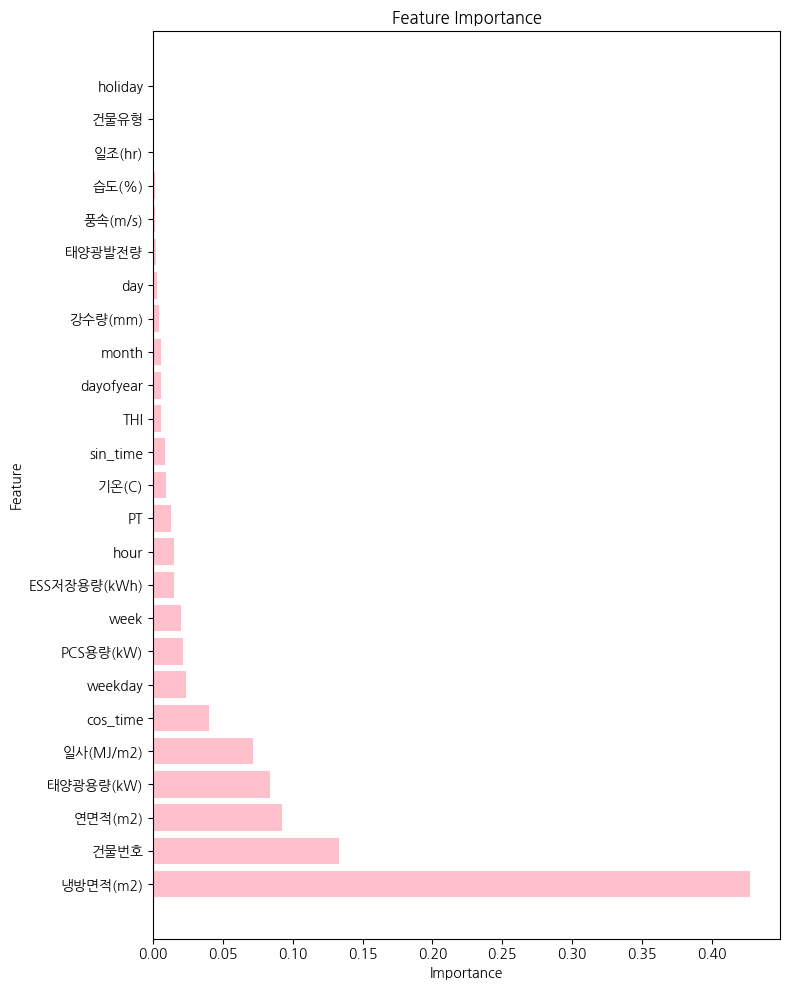

In [ ]:
# 특성과 타겟 변수 선택
X = train_ft.drop('전력소비량(kWh)', axis=1)
y = target

# XGBoost 모델 파라미터 설정
params = {#파라미터 튜닝은 <학습과 예측>의 autoML 참고
    'objective':  'reg:squarederror',  # 회귀 문제 설정 (MSE)
    'learning_rate': 0.4,  # 학습률
    'n_estimators': 20,  # 트리의 개수
    'subsample': 1.0,  # 각 트리마다 사용할 데이터 샘플링 비율
    'colsample_bytree': 1.0,  # 각 트리마다 사용할 특성 샘플링 비율
    'random_state': 42  # 랜덤 시드 고정
}

# K-Fold Cross-validation을 위한 설정
k = 5  # 폴드 수
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 전체 데이터로 최종 모델 학습
final_model = xgb.XGBRegressor(**params)
final_model.fit(X, y)

# 특성 중요도 출력
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(f"\nFeature Importance:")
print(feature_importance)


# 특성 중요도 시각화
plt.figure(figsize=(8, 10))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], align='center', color='pink')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## 1-b. clustering

In [ ]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = train_ft.groupby(['건물번호','weekday'])['전력소비량(kWh)'].median().reset_index().pivot(index='건물번호', columns='weekday', values='전력소비량(kWh)').reset_index('건물번호').drop('건물번호', axis=1)
by_hour = train_ft.groupby(['건물번호','hour'])['전력소비량(kWh)'].median().reset_index().pivot(index='건물번호', columns='hour', values='전력소비량(kWh)').reset_index('건물번호').drop('건물번호', axis=1)
df = pd.concat([by_weekday, by_hour], axis=1)

In [ ]:
df.head()

,0,1,2,3,4,5,6,0,1,2,...,14,15,16,17,18,19,20,21,22,23
0,2388.48,2585.52,2455.92,2484.00,2599.68,2506.08,2116.80,1770.24,1714.56,1602.72,...,4336.32,4216.32,4140.96,3607.68,2894.40,2733.60,2504.64,1986.72,1459.68,1867.68
1,1219.32,1755.90,1546.38,1723.68,1517.22,1644.66,1465.02,1239.84,1229.04,1222.20,...,2382.84,2415.24,2453.76,2292.84,2354.40,2039.40,1829.16,1514.88,831.24,1289.16
2,1119.60,1290.78,1236.42,1302.12,1318.32,1271.16,1255.68,959.76,908.64,885.24,...,1692.36,1871.28,1963.08,2055.24,2524.68,2616.12,2462.04,1949.04,1150.56,1018.80
3,902.07,910.26,884.52,889.29,880.92,875.34,873.63,717.66,709.20,715.86,...,1332.54,1323.18,1299.06,1187.82,1026.36,870.48,820.80,782.10,764.28,721.08
4,1789.20,1822.32,1941.84,2030.76,2472.12,2739.96,2277.72,1839.60,1825.20,1793.52,...,3434.40,3309.84,2921.76,2541.60,2094.48,1846.08,1781.28,1724.40,1674.72,1658.88


In [ ]:
# 요일 데이터를 월화수목금토일로 변경
weekday_columns = ['월', '화', '수', '목', '금', '토', '일']

# 시간 데이터에 '시'를 붙여서 변경
hour_columns = [str(i).zfill(2) + '시' for i in range(24)]

# 열 이름 리스트를 합쳐서 전체 열 이름으로 설정
new_columns = weekday_columns + hour_columns
df.columns = new_columns

In [ ]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,0:7] = (df.iloc[i,0:7] - df.iloc[i,0:7].mean())/df.iloc[i,0:7].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,7:] = (df.iloc[i,7:] - df.iloc[i,7:].mean())/df.iloc[i,7:].std()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state = 2, n_init = 'auto', init='k-means++')
km_cluster = kmeans.fit_predict(df)
df['km_cluster'] = km_cluster #데이터프레임에 클러스터링 결과 추가

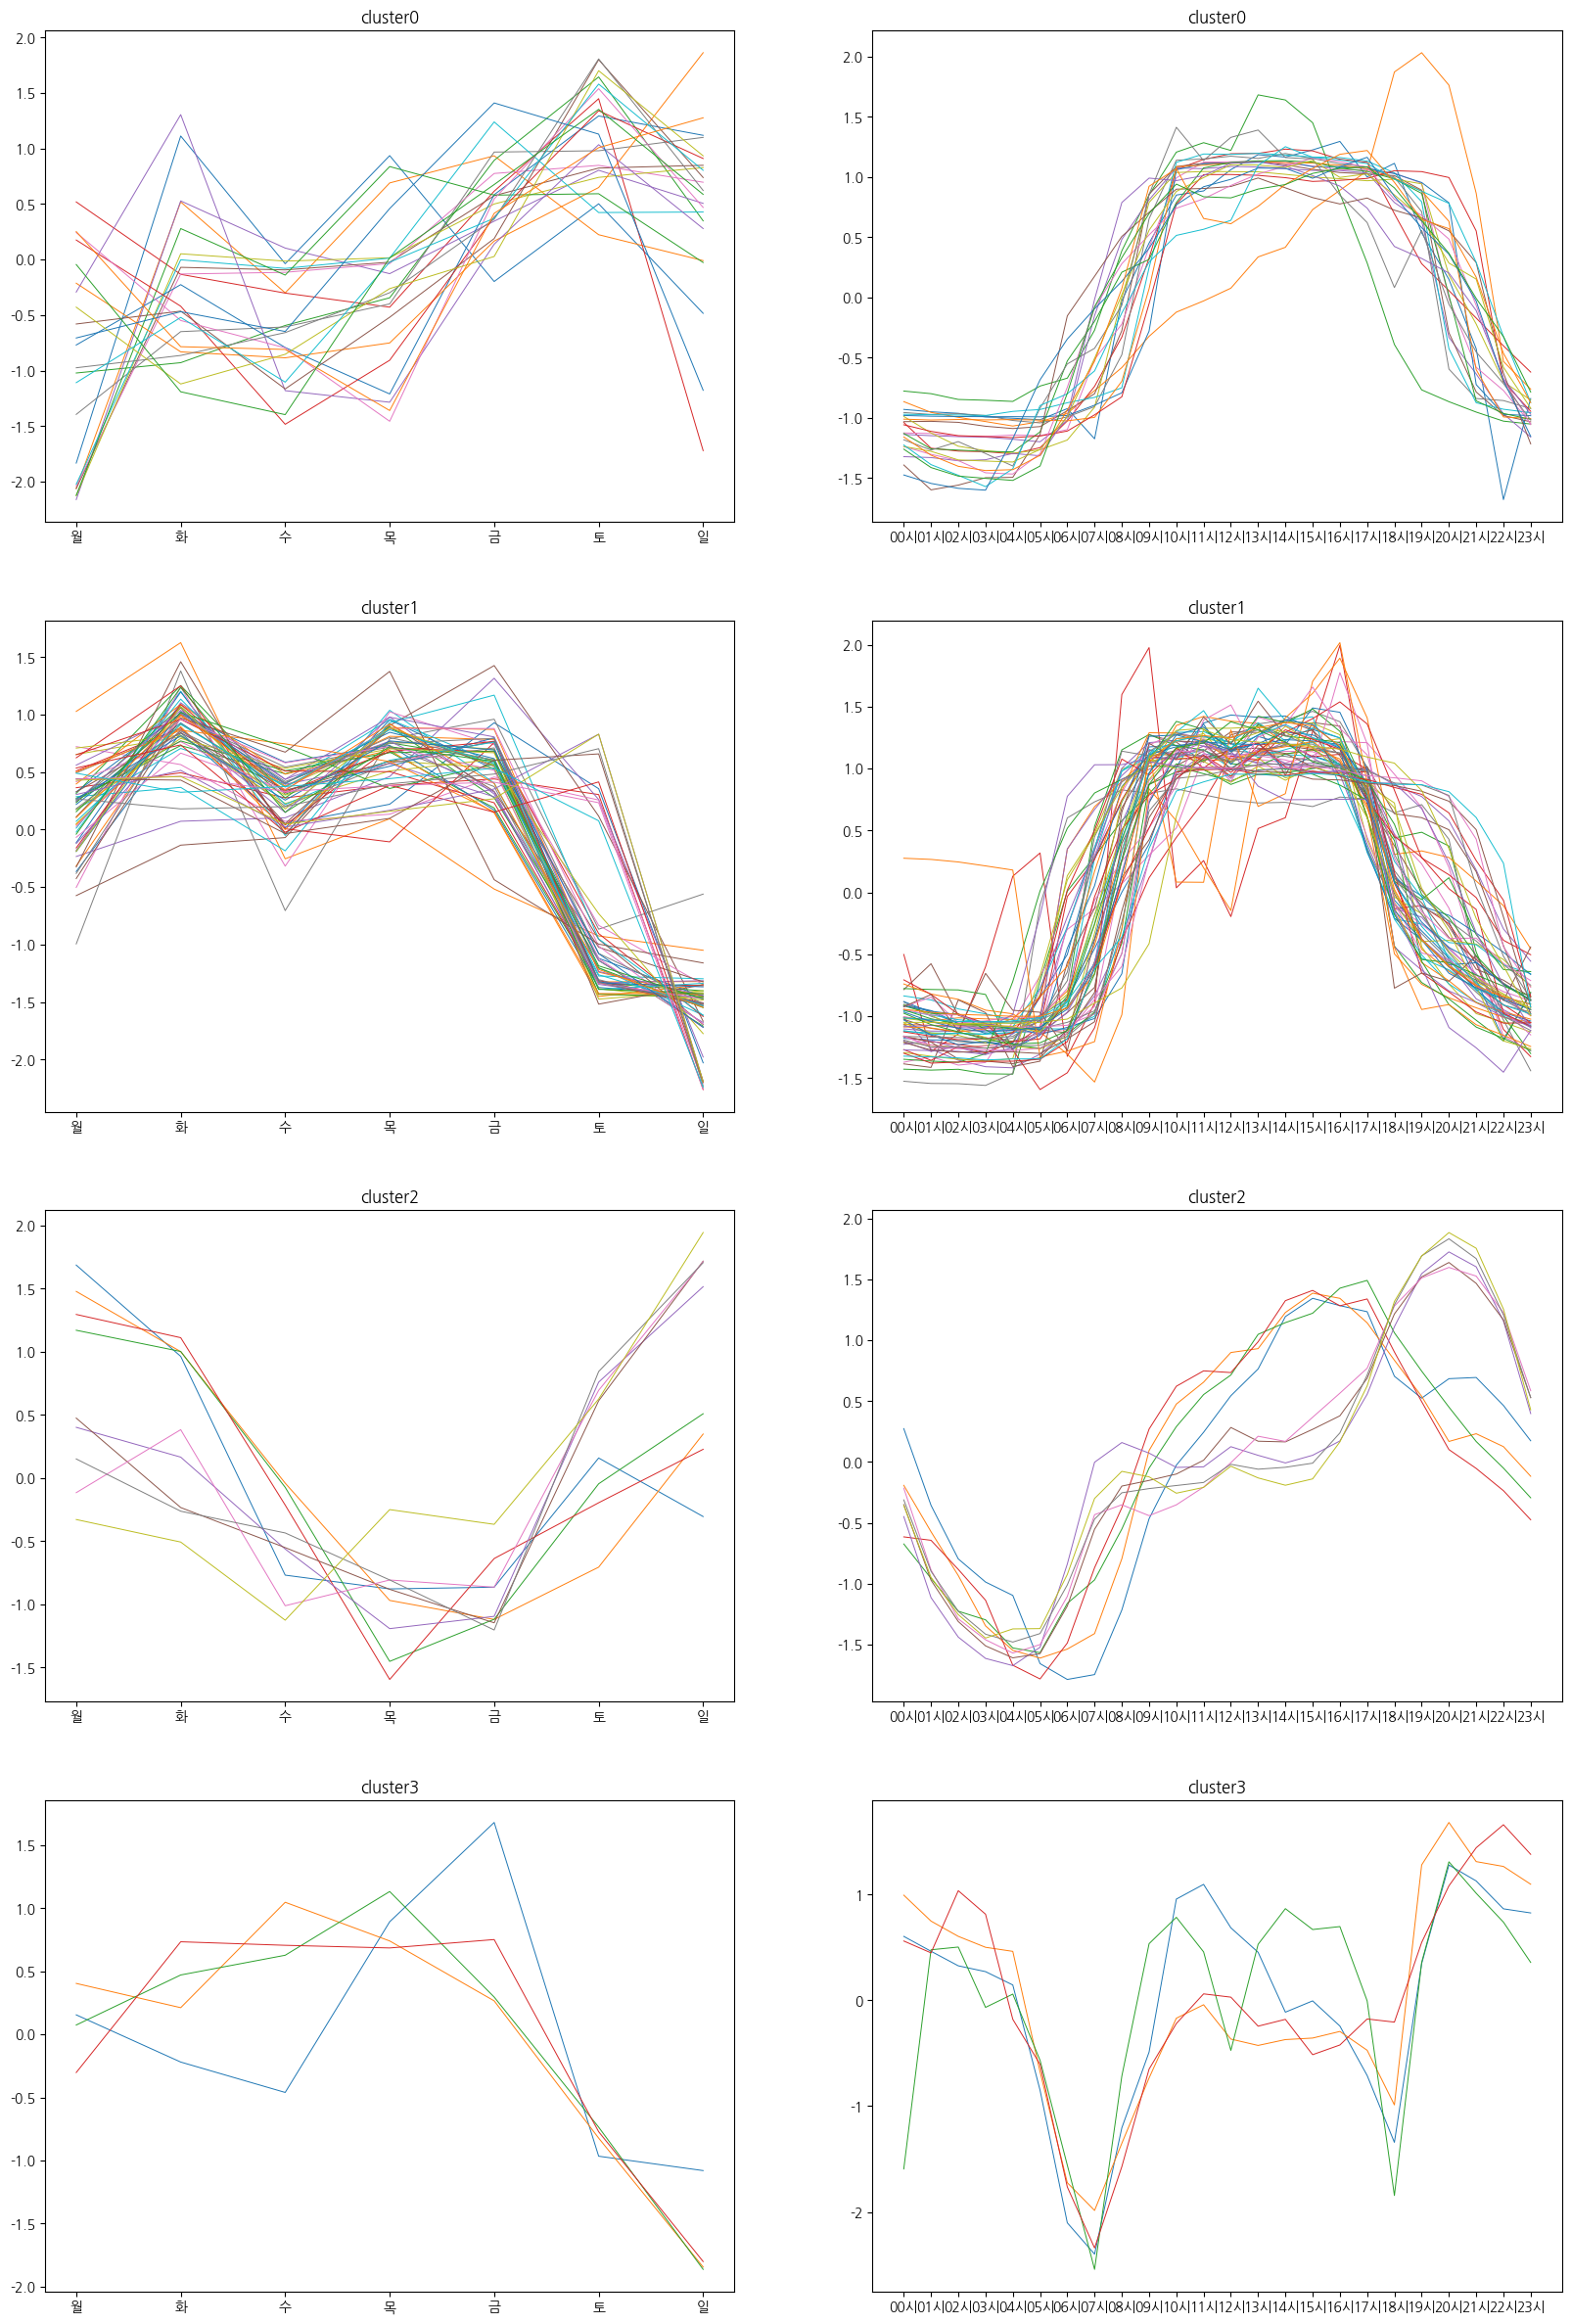

In [ ]:
# 클러스터링 결과 시각화
n_c = len(np.unique(df.km_cluster))  #클러스터수

fig = plt.figure(figsize = (20,30))
for c in range(n_c):
    temp = df[df.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,0:7], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks(['월', '화', '수', '목', '금', '토', '일'])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,7:-1], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks(range(24))

클러스터별로 데이터프레임 만들기

In [ ]:
# train_df와 df를 '건물번호'를 기준으로 병합
cluster_df = train_ft.merge(df['km_cluster'], left_on='건물번호', right_index=True)
if 'Unnamed: 0' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Unnamed: 0'])

In [ ]:
#클러스터별로 다른 df로 저장
cluster_0 = cluster_df[cluster_df['km_cluster'] == 0]
cluster_1 = cluster_df[cluster_df['km_cluster'] == 1]
cluster_2 = cluster_df[cluster_df['km_cluster'] == 2]
cluster_3 = cluster_df[cluster_df['km_cluster'] == 3]

In [ ]:
# 데이터프레임을 CSV 파일로 저장 (인덱스는 저장하지 않음)
cluster_0.to_csv('cluster_0.csv', index=False)
cluster_1.to_csv('cluster_1.csv', index=False)
cluster_2.to_csv('cluster_2.csv', index=False)
cluster_3.to_csv('cluster_3.csv', index=False)


클러스터별로 건물 유형 확인

In [ ]:
type_dict = {
    0: '건물기타',
    1: '공공',
    2: '대학교',
    3: '데이터센터',
    4: '백화점 및 아울렛',
    5: '병원',
    6: '상용',
    7: '아파트',
    8: '연구소',
    9: '지식산업센터',
    10: '할인마트',
    11: '호텔 및 리조트'
}
#train_ft['건물유형'] = train_ft['건물유형'].map(type_dict)

In [ ]:
# 클러스터별 건물유형 빈도수 계산 함수 정의
def cluster_type_counts(df):
     building_type_counts = df['건물유형'].map(type_dict).value_counts() / 2040
     return building_type_counts

cluster0_cnt = cluster_type_counts(cluster_0).sort_index()
cluster1_cnt = cluster_type_counts(cluster_1).sort_index()
cluster2_cnt = cluster_type_counts(cluster_2).sort_index()
cluster3_cnt = cluster_type_counts(cluster_3).sort_index()

# 결과 출력
print("Cluster 0 건물유형 빈도수:")
print(cluster0_cnt)
print("Cluster 1 건물유형 빈도수:")
print(cluster1_cnt)
print("Cluster 2 건물유형 빈도수:")
print(cluster2_cnt)
print("Cluster 3 건물유형 빈도수:")
print(cluster3_cnt)

Cluster 0 건물유형 빈도수:
건물유형
건물기타         4.0
데이터센터        1.0
백화점 및 아울렛    7.0
상용           1.0
연구소          1.0
지식산업센터       1.0
할인마트         5.0
호텔 및 리조트     3.0
Name: count, dtype: float64
Cluster 1 건물유형 빈도수:
건물유형
건물기타         7.0
공공           8.0
대학교          7.0
데이터센터        1.0
백화점 및 아울렛    1.0
병원           8.0
상용           6.0
아파트          1.0
연구소          7.0
지식산업센터       6.0
할인마트         3.0
Name: count, dtype: float64
Cluster 2 건물유형 빈도수:
건물유형
대학교      1.0
데이터센터    3.0
상용       1.0
아파트      4.0
Name: count, dtype: float64
Cluster 3 건물유형 빈도수:
건물유형
건물기타    4.0
Name: count, dtype: float64


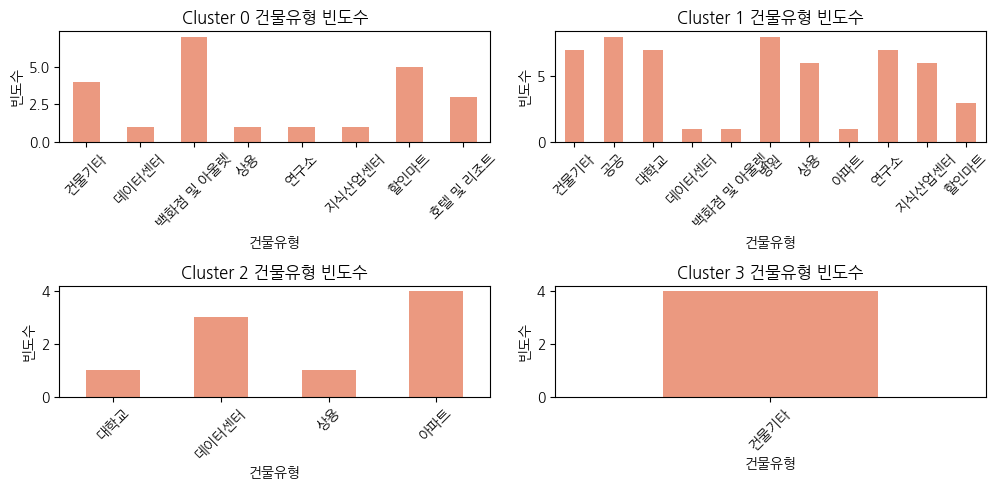

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
cluster0_cnt.plot(kind='bar', color='#EB9980')
plt.title('Cluster 0 건물유형 빈도수')
plt.xlabel('건물유형')
plt.ylabel('빈도수')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
cluster1_cnt.plot(kind='bar', color='#EB9980')
plt.title('Cluster 1 건물유형 빈도수')
plt.xlabel('건물유형')
plt.ylabel('빈도수')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
cluster2_cnt.plot(kind='bar', color='#EB9980')
plt.title('Cluster 2 건물유형 빈도수')
plt.xlabel('건물유형')
plt.ylabel('빈도수')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
cluster3_cnt.plot(kind='bar', color='#EB9980')
plt.title('Cluster 3 건물유형 빈도수')
plt.xlabel('건물유형')
plt.ylabel('빈도수')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 인사이트2. 태양광

In [ ]:
import seaborn as sns
from scipy import stats
from scipy.stats import levene, bartlett, shapiro

In [ ]:
# 태양광설비가 있는 건물과 없는 건물을 나누기
solar_present = train_ft[train_ft['태양광용량(kW)'] > 0]
solar_absent = train_ft[train_ft['태양광용량(kW)'] == 0]

## 2-a. 태양광 설비 설치 여부에 따른 전력소비량 차이가 있다.

In [ ]:
# 등분산성 검정
statistic_levene, p_value_levene = levene(solar_present['전력소비량(kWh)'], solar_absent['전력소비량(kWh)'])
statistic_bartlett, p_value_bartlett = bartlett(solar_present['전력소비량(kWh)'], solar_absent['전력소비량(kWh)'])

# 정규성 검정
statistic_shapiro_present, p_value_shapiro_present = shapiro(solar_present['전력소비량(kWh)'])
statistic_shapiro_absent, p_value_shapiro_absent = shapiro(solar_absent['전력소비량(kWh)'])

print("등분산성 검정 (Levene): p-value =", p_value_levene)
print("등분산성 검정 (Bartlett): p-value =", p_value_bartlett)
print("정규성 검정 (태양광설비 있음): p-value =", p_value_shapiro_present)
print("정규성 검정 (태양광설비 없음): p-value =", p_value_shapiro_absent)

등분산성 검정 (Levene): p-value = 0.0
등분산성 검정 (Bartlett): p-value = 0.0
정규성 검정 (태양광설비 있음): p-value = 0.0
정규성 검정 (태양광설비 없음): p-value = 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## 2-b. 요일, 시간별 클러스터별로 설치 비율 확인하기

In [ ]:
#cluster_0
# '태양광용량'이 0보다 큰 행들을 train_o 데이터프레임으로 분류
cluster_0_o = cluster_0[cluster_0['태양광용량(kW)'] > 0]

# '태양광용량'이 0인 행들을 train_x 데이터프레임으로 분류
cluster_0_x = cluster_0[cluster_0['태양광용량(kW)'] == 0]

#cluster_1
cluster_1_o = cluster_1[cluster_1['태양광용량(kW)'] > 0]
cluster_1_x = cluster_1[cluster_1['태양광용량(kW)'] == 0]

#cluster_2
cluster_2_o = cluster_2[cluster_2['태양광용량(kW)'] > 0]
cluster_2_x = cluster_2[cluster_2['태양광용량(kW)'] == 0]

#cluster_3
cluster_3_o = cluster_3[cluster_3['태양광용량(kW)'] > 0]
cluster_3_x = cluster_3[cluster_3['태양광용량(kW)'] == 0]

In [ ]:
def solar_building_summary(df):
  # 태양광 설비 있는 건물 세기
  o_count = df.groupby('건물번호').apply(lambda x: (x['태양광용량(kW)'] > 0).any()).sum()

  # 태양광 설비 없는 건물 세기
  x_count = df.groupby('건물번호').apply(lambda x: (x['태양광용량(kW)'] == 0).all()).sum()

  # 전체 건물 수
  total_count = df['건물번호'].nunique()

  # 비율 계산
  o_ratio = o_count / total_count
  x_ratio = x_count / total_count

  # 결과 출력
  print("태양광발전 설비 설치 건물의 수:", o_count)
  print("태양광발전 설비 미설치 건물의 수:", x_count)
  print("전체 건물 수:", total_count)
  print("태양광발전 설비 설치 건물의 비율:", o_ratio)
  print("태양광발전 설비 미설치 건물의 비율:", x_ratio)

  # Seaborn의 색상 팔레트 설정
  palette = sns.color_palette("husl", 2)

  # 시각화 - 파이 차트
  labels = ['태양광발전 설비 설치 건물', '태양광발전 설비 미설치 건물']
  sizes = [o_count, x_count]

  plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=palette)
  plt.axis('equal')
  plt.show()

태양광발전 설비 설치 건물의 수: 5
태양광발전 설비 미설치 건물의 수: 18
전체 건물 수: 23
태양광발전 설비 설치 건물의 비율: 0.21739130434782608
태양광발전 설비 미설치 건물의 비율: 0.782608695652174


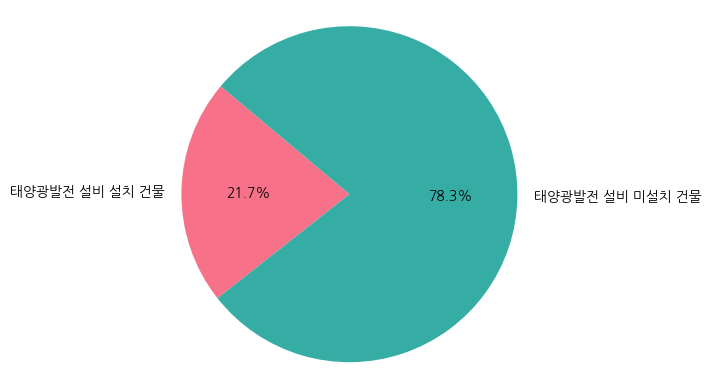

In [ ]:
solar_building_summary(cluster_0)

태양광발전 설비 설치 건물의 수: 27
태양광발전 설비 미설치 건물의 수: 28
전체 건물 수: 55
태양광발전 설비 설치 건물의 비율: 0.4909090909090909
태양광발전 설비 미설치 건물의 비율: 0.509090909090909


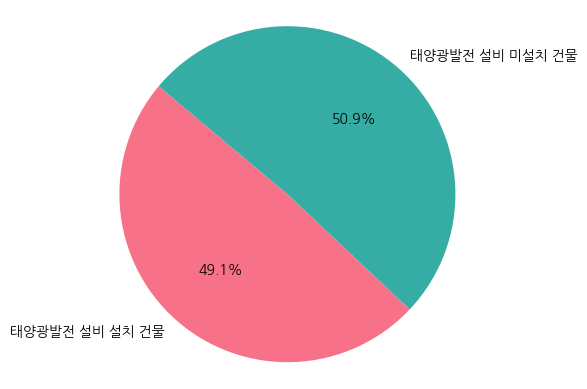

In [ ]:
solar_building_summary(cluster_1)

태양광발전 설비 설치 건물의 수: 2
태양광발전 설비 미설치 건물의 수: 7
전체 건물 수: 9
태양광발전 설비 설치 건물의 비율: 0.2222222222222222
태양광발전 설비 미설치 건물의 비율: 0.7777777777777778


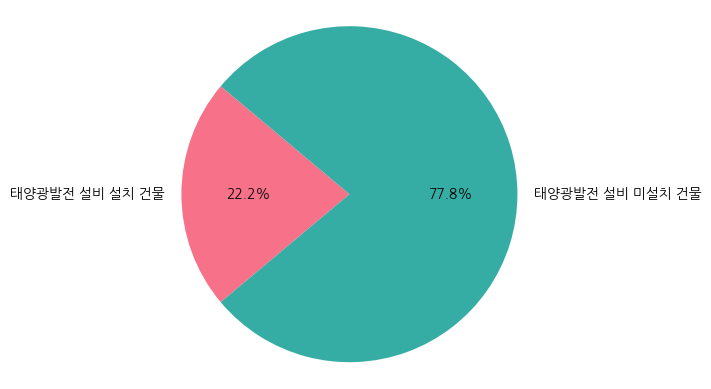

In [ ]:
solar_building_summary(cluster_2)

태양광발전 설비 설치 건물의 수: 2
태양광발전 설비 미설치 건물의 수: 2
전체 건물 수: 4
태양광발전 설비 설치 건물의 비율: 0.5
태양광발전 설비 미설치 건물의 비율: 0.5


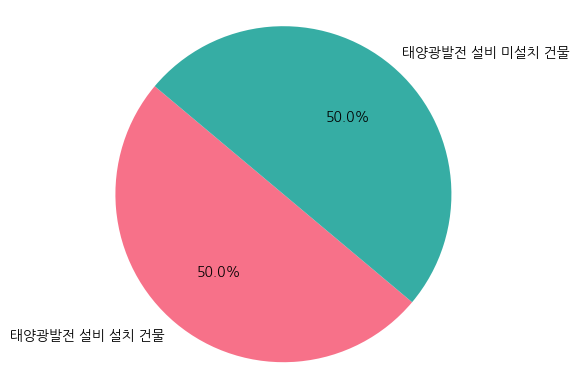

In [ ]:
solar_building_summary(cluster_3)

## 2-c. 건물유형별 태양광용량 설치 여부 확인

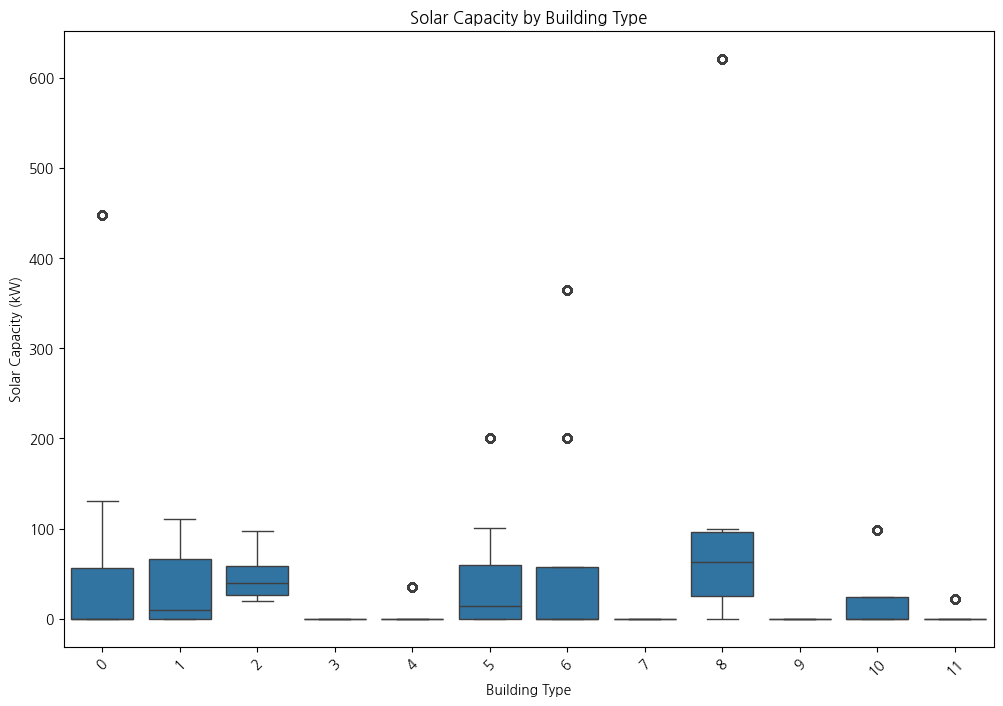

In [ ]:
building_data = pd.DataFrame({
    'solar_installed': train_ft['태양광용량(kW)'],
    'building_info': train_ft['건물유형'].astype(int)
})

# 건물 유형 리스트
building_types = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# 건물 유형을 인덱스 번호로 매핑
building_data['building_info'] = building_data['building_info'].map(lambda x: building_types[x])

# 건물 유형별로 태양광 설치 여부에 따른 상자 그림 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='building_info', y='solar_installed', data=building_data)
plt.title('Solar Capacity by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Solar Capacity (kW)')
plt.xticks(rotation=45)  # x축 눈금 라벨 회전
plt.show()

# 인사이트3. 성수기

In [ ]:
df_building = train_ft[train_ft['건물번호'] == 96]
df_building.columns

Index(['건물번호', '냉방면적(m2)', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)',
       '일사(MJ/m2)', '전력소비량(kWh)', 'hour', 'day', 'weekday', 'month', 'week',
       'dayofyear', '건물유형', '연면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)', 'holiday', 'sin_time', 'cos_time', 'THI', 'PT', '태양광발전량'],
      dtype='object')

In [ ]:
def plot_temp_power(building_num):
    # 건물번호가 building_num인 데이터만 선택
    df_building = train_ft[train_ft['건물번호'] == building_num]

    # 평균계산, 시각화를 위해 날짜열 다시 만들어주기
    df_building['year'] = 2022
    df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])

    # 각 날짜별 전력소비량의 평균 계산
    daily_avg_power_consumption = df_building.groupby('date')['전력소비량(kWh)'].mean()
    # 각 날짜별 기온의 평균 계산
    daily_avg_temperature = df_building.groupby('date')['기온(C)'].mean()

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('일별 평균 기온', color=color, fontsize=14)
    ax1.plot(daily_avg_temperature.index, daily_avg_temperature, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()
    color = 'tab:pink'
    ax2.set_ylabel('일별 평균 전력소비량', color=color, fontsize=14)
    ax2.plot(daily_avg_power_consumption.index, daily_avg_power_consumption, marker='o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'건물번호 {building_num}의 일별 평균 기온 및 전력소비량', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


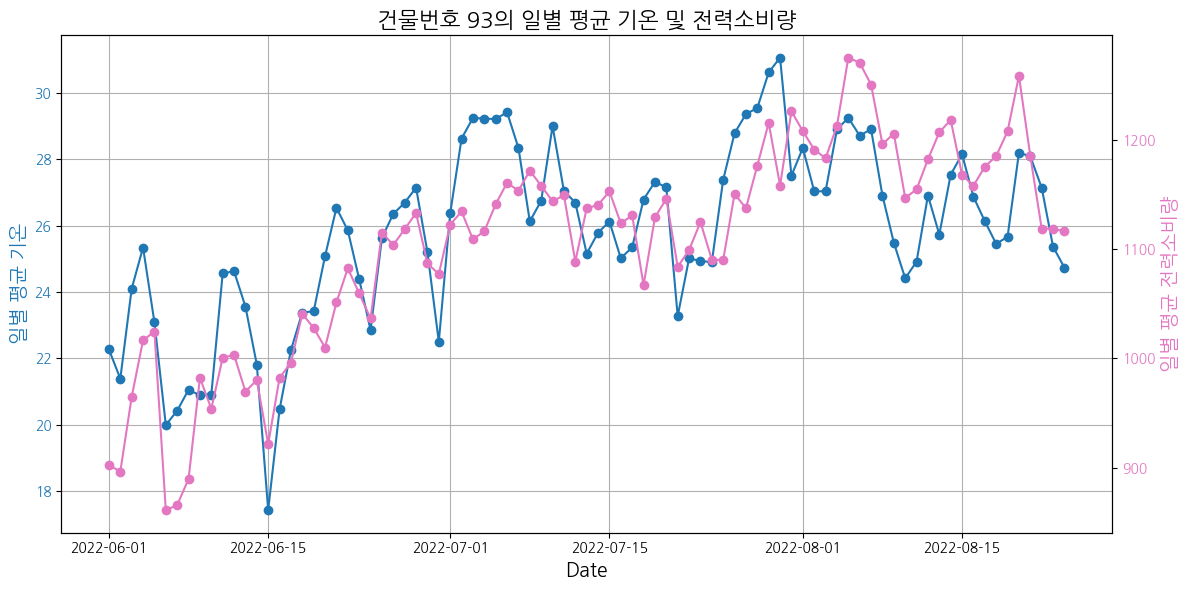

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


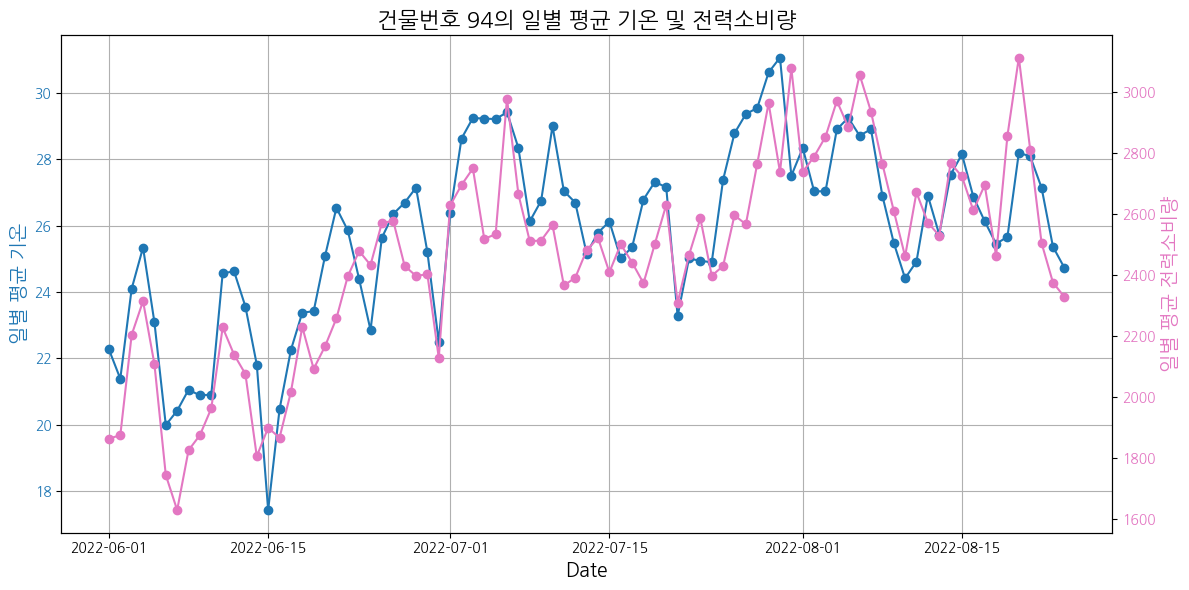

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


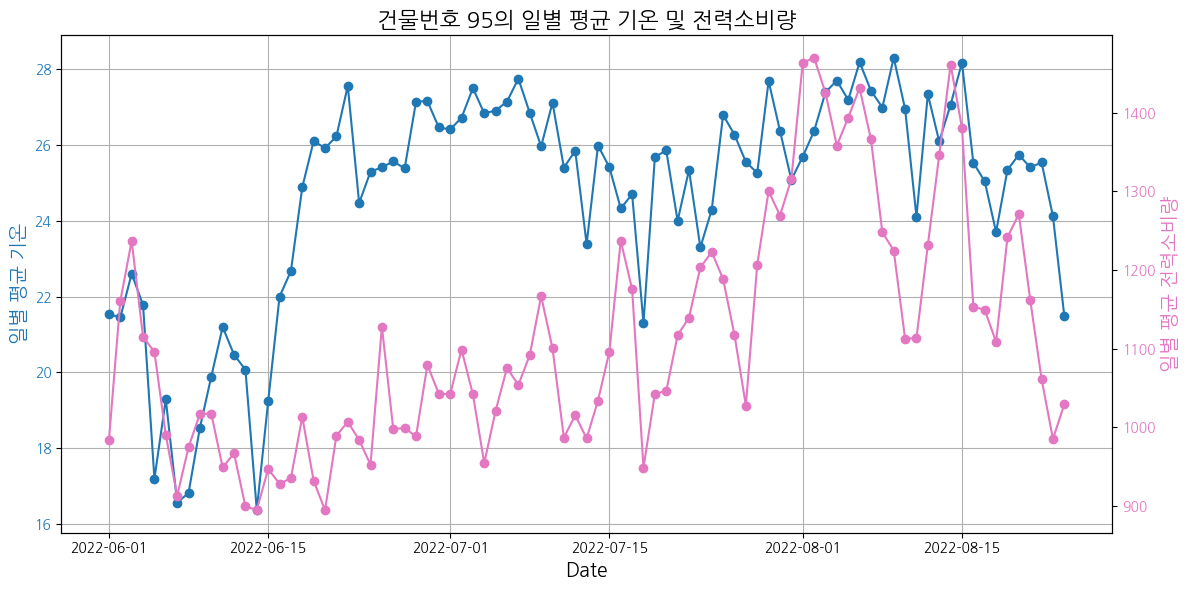

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


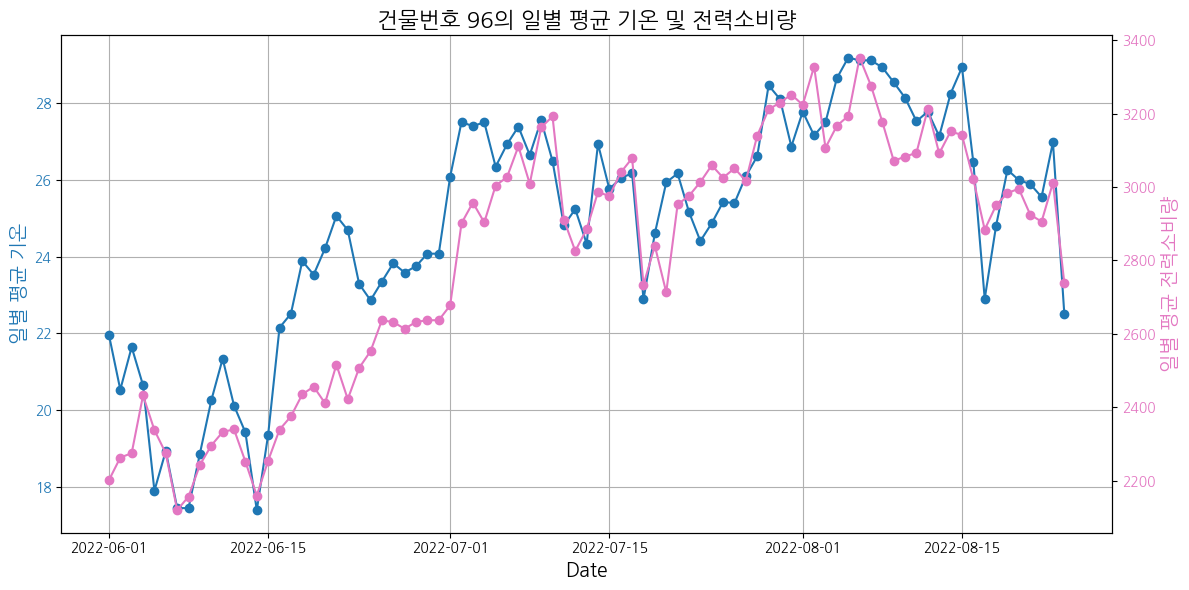

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


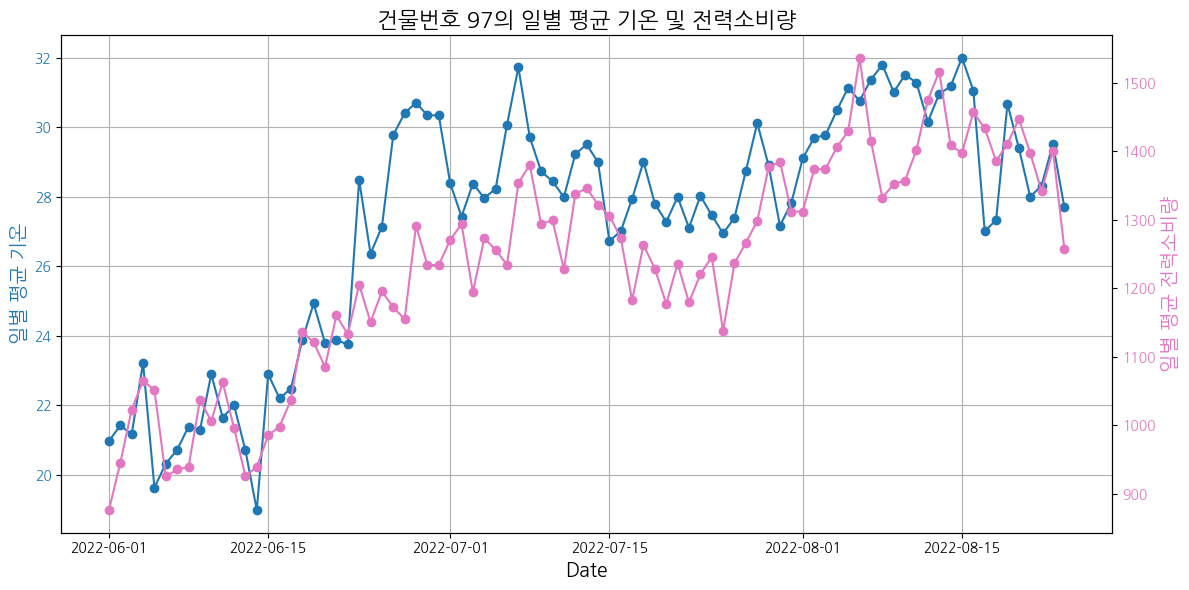

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


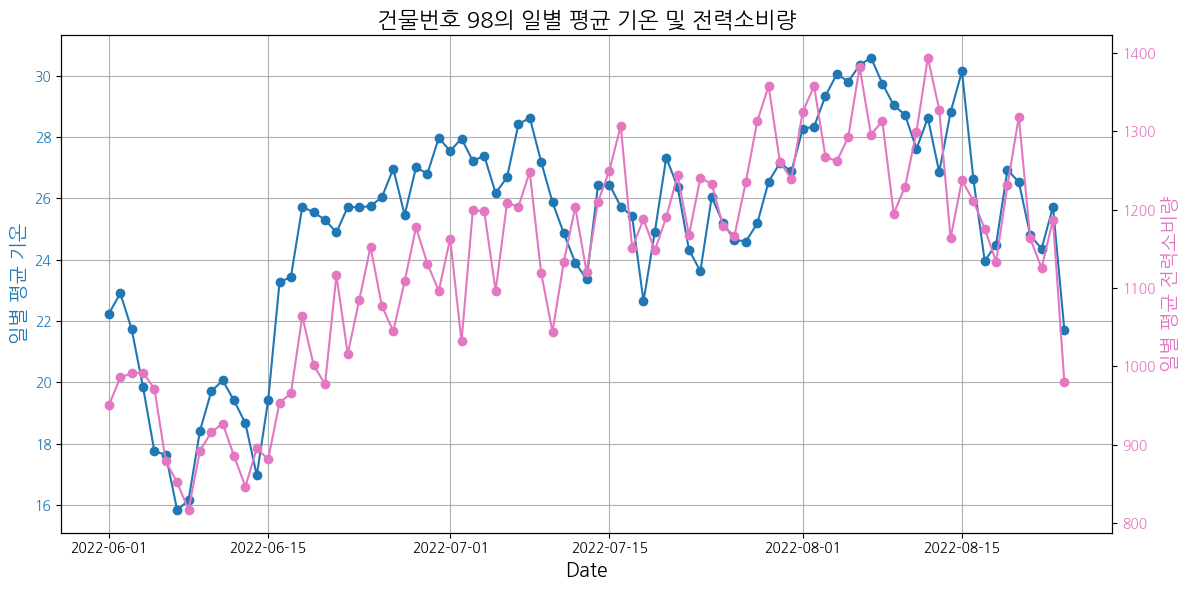

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


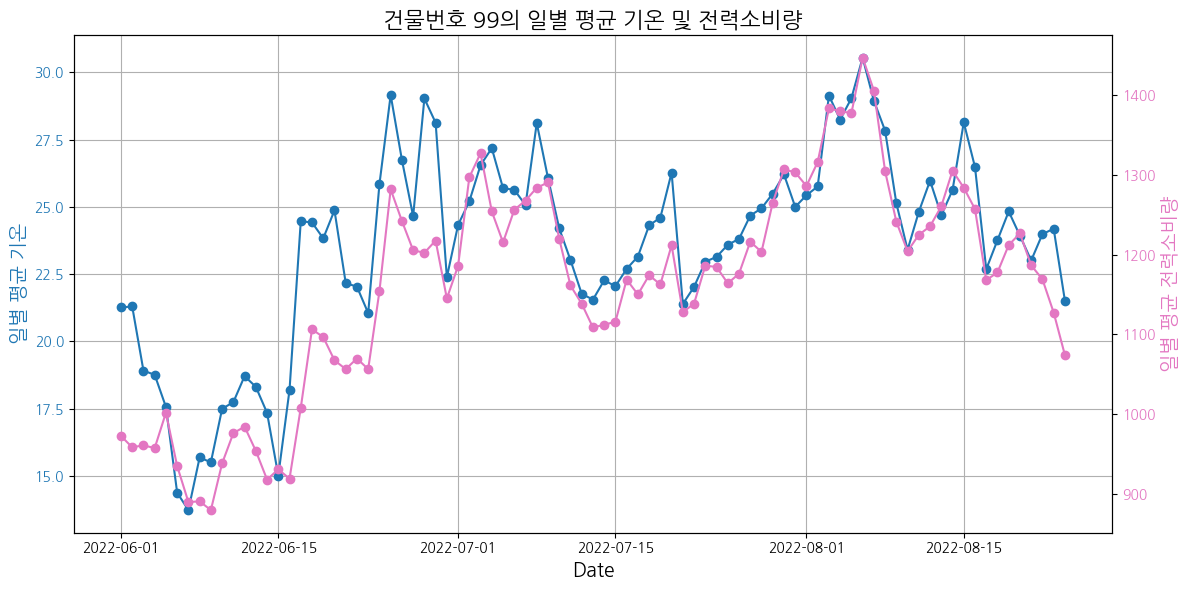

<ipython-input-49-5f1ffb72d7d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['year'] = 2022
<ipython-input-49-5f1ffb72d7d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_building['date'] = pd.to_datetime(df_building[['year', 'month', 'day']])


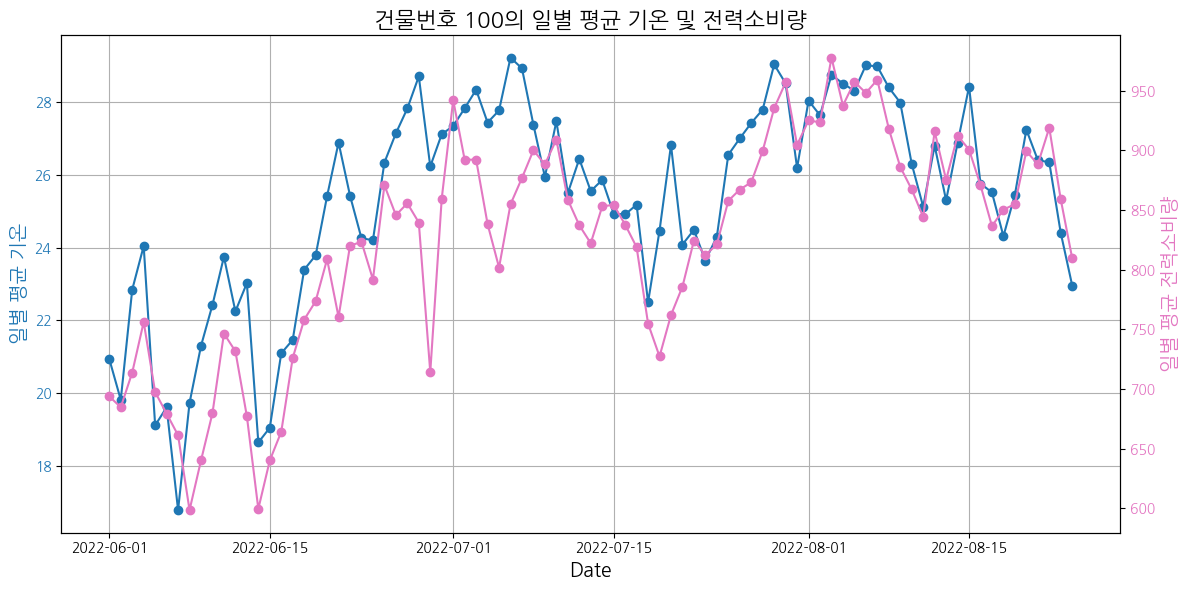

In [ ]:
for i in range(93, 101):
  plot_temp_power(i)

# 학습과 예측

In [ ]:
pip install pycaret

In [ ]:
pip install catboost

In [ ]:
#import 모음
from catboost import CatBoostRegressor
from pycaret.regression import *
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
#데이터불러오기
train_ml = pd.read_csv('train_ml.csv')
test_ml = pd.read_csv('test_ml.csv')

In [ ]:
# 종속변수(target)와 독립변수(features) 분리
target = '전력소비량(kWh)'
features = train_ml.columns.drop(labels=[target])

X = train_ml[features]
y = train_ml[target]

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## AUTO ML

In [ ]:
exp_clf = setup(data = train_ml, target = '전력소비량(kWh)', session_id=123)

,Description,Value
0,Session id,123
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(195840, 23)"
4,Transformed data shape,"(195840, 23)"
5,Transformed train set shape,"(137088, 23)"
6,Transformed test set shape,"(58752, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


In [ ]:
models() #가지고 있는 모델 확인하기

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
best_model = compare_models()
#프로젝트 과정에서는 knn이 가장 성능이 좋은 것으로 나와서 knn과
#가이드 코드에 있는 세 개의 모델을 사용했다.
#compare_models()의 순위가 실행마다 달라지는 것 같다.

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:46:56
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Lasso Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1371.7775,5423902.4960,2328.6306,0.1054,0.7019,0.8253,1.9010


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Tune_model()
- 하이퍼 파라미터를 튜닝하기 위해, `tune_model`함수를 사용한다.

- `tune_model` 함수는 자동으로 RandomGridSearch를 사용해서 하이퍼파라미터를 튜닝한다.

In [ ]:
xgboost = create_model('xgboost')

tuned_xgboost = tune_model(xgboost)
params = tuned_xgboost.get_params()
print(params)

In [ ]:
lightgbm = create_model('lightgbm')

tuned_lightgbm = tune_model(lightgbm)
params = tuned_lightgbm.get_params()
print(params)

In [ ]:
catboost = create_model('catboost')

tuned_catboost = tune_model(catboost)
params = tuned_catboost.get_params()
print(params)

In [ ]:
knn = create_model('knn')

tuned_knn = tune_model(knn)
print(tuned_knn)

params = tuned_knn.get_params()
print(params)

## XGBOOST

학습

In [ ]:
# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(base_score=None, booster='gbtree', callbacks=None, colsample_bylevel=None,
                         colsample_bynode=None, colsample_bytree=0.5, device='cpu', early_stopping_rounds=None,
                         enable_categorical=False, eval_metric=None, feature_types=None, gamma=None,
                         grow_policy=None, importance_type=None, interaction_constraints=None,
                         learning_rate=0.3, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                         max_delta_step=None, max_depth=5, max_leaves=None, min_child_weight=1,
                          monotone_constraints=None, multi_strategy=None,
                         n_estimators=70, n_jobs=-1, num_parallel_tree=None)

xgb_model.fit(X_train, y_train)

In [ ]:
# 모델 평가
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

## LIGHT GBM

학습

In [ ]:
# 하이퍼파라미터 설정
params = {
    'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split',
    'learning_rate': 0.4, 'max_depth': -1, 'min_child_samples': 6, 'min_child_weight': 0.001,
    'min_split_gain': 0.3, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 150, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'feature_fraction': 0.5, 'bagging_freq': 3,
    'bagging_fraction': 0.9
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration_)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    rmse_scores.append(rmse)

print(f'Average RMSE: {np.mean(rmse_scores)}')



## CATBOOST

학습

In [ ]:
# CatBoost 모델 초기화 및 학습: catboost에서 제시해준 기본 파라미터값
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# 검증 데이터에 대한 예측 수행
y_pred = cat_model.predict(X_test)

# 검증 데이터에 대한 평가 (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("검증 데이터 RMSE:", rmse)

## KNN REGRESSOR

학습

In [ ]:
knr = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_jobs=-1, n_neighbors=16, p=2, weights='uniform')

KNN = knr.fit(X_train,y_train)
prediction = KNN.predict(X_test)

from sklearn import metrics

#R2
print('R2:', metrics.r2_score(y_test, prediction))

# RMSE
RMSE = np.sqrt(metrics.mean_squared_error(y_test, prediction))
print('RMSE:', RMSE)

## 예측

In [ ]:
test_features = test_ml.columns.drop(labels=['전력소비량(kWh)'])
test_X = test_ml[test_features]


In [ ]:
pred = test_ml[['건물번호', 'dayofyear']]

In [ ]:
# xgb
pred['xgb_pred'] = xgb_model.predict(test_ml)

#lgbm
lgbm_model = lgb.LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
pred['lgbm_pred'] = lgbm_model.predict(test_ml['전력소비량(kWh)'])

#catboost
pred['cat_pred'] = cat_model.predict(test_ml['전력소비량(kWh)'])

# knn
pred['knn_pred'] = KNN.predict(test_ml['전력소비량(kWh)'])

#네 개 예측값의 평균
pred['ensemble_pred'] = (pred['xgb_pred'] + pred['lgbm_pred'] + pred['cat_pred'] + pred['knn_pred']) / 4


In [ ]:
pred

In [ ]:
pred.to_csv('전력소비량_예측.csv')